In [1]:
from PINNs import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS

In [2]:
dtype=torch.float64
num_x = 100                                                        
num_t = 100                                                        
num_ic = 100                                           
num_int = 10000                                            
Time = 5
L = 1
Tstart = 0
Tend = 5
Xstart = -1
Xend = 2

In [3]:
def train(epoch):
    def closure():
      optimizer.zero_grad()                                              
      
      loss_pde = model.loss_pde(x_int) 
      loss_ic = model.loss_ic(x_ic,u_ic)
      loss_bcL = model.loss_ic(x_bcL,u_bcL)
      loss_bcR = model.loss_outflow2(x_bcR,x_bcRP)
      #loss_bd =  0.0*model.loss_bd(x_bdL_ignore,u_bdL_ignore)
      loss = loss_pde + 10*(loss_ic+loss_bcL+loss_bcR)#+loss_bcR)##+10*loss_bd 

      print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
      loss.backward()
      return loss
    loss = optimizer.step(closure)
    return loss 

In [6]:
l2 = 0
lmax = 0
for i in range(10):
  setup_seed(10)

  x_ic,x_bc,x_int = Mesh_Data(num_x,num_t,Tstart,Tend, Xstart,Xend)
  x_bcL = np.zeros((num_t,2))
  x_bcR = np.zeros((num_t,2))
  x_bcL = x_bc[:num_t-1,:]
  x_bcR = x_bc[num_t-1:,:]
  x_bcRP = x_bc[num_t-1:,:]
  x_bcRP[:,1] = x_bcRP[:,1] + 0.03
  u_bcL = BC_Sin_L(x_bcL)
  u_bcR = BC_Constant(x_bcR)
  xlimits = np.array([[0.,Time],[-L, 2*L]])  #interal
  sampling = LHS(xlimits=xlimits)
  x_int= sampling(num_int)
  xlimits = np.array([[0.,0.0],[-L, 2*L]])  #interal
  sampling = LHS(xlimits=xlimits)
  x_ic= sampling(num_ic)
  u_ic = IC_Sin_Case1(x_ic)
  x_ic = torch.tensor(x_ic, dtype=dtype).to(cuda)
  u_ic = torch.tensor(u_ic, dtype=dtype).to(cuda)
  x_bcL = torch.tensor(x_bcL, dtype=dtype).to(cuda)
  x_bcR = torch.tensor(x_bcR,requires_grad=True, dtype=dtype).to(cuda)
  x_bcRP = torch.tensor(x_bcRP,requires_grad=True, dtype=dtype).to(cuda)
  u_bcL = torch.tensor(u_bcL, dtype=dtype).to(cuda)
  u_bcR = torch.tensor(u_bcR, dtype=dtype).to(cuda)
  x_int= torch.tensor(x_int,requires_grad=True,dtype=dtype).to(cuda)

  model = PINNs_scalar_1D(Nl=5,Nn=30).to(cuda).double()

  epoch = 0
  epochi = epoch
  lr = 0.001                                                           # Learning rate
  #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  #epochs = 100000
  #loss_history=[]
  #tic = time.time()
  #for epoch in range(1+epochi, epochs+epochi):
  #    loss = train(epoch)
  #    print(f'loss_tot:{loss:.8f}')
  #    loss_history.append(to_numpy(loss))
  #    if loss < 0.05:
  #        break
  #toc = time.time()
  #print(f'Total training time: {toc - tic}')

  optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)
  epochi = epoch

  epochs = 2000
  tic = time.time()
  for epoch in range(epochi, epochs+epochi):
      loss = train(epoch)
      print(f'loss_tot:{loss:.8f}')
     # loss_history.append(to_numpy(loss))
      #if loss < 0.01:
      #    break
  toc = time.time()

  print(f'Total training time: {toc - tic}')

  Nd = 400
  x = np.linspace(-1.0, 2.0, 100)                                  
  t = np.linspace(5, 5, 1)                         
  t_grid, x_grid = np.meshgrid(t, x)                              
  T = t_grid.flatten()[:, None]                                   
  X = x_grid.flatten()[:, None]                                   
  x_test = np.hstack((T, X))                                      
  x_e =  x_test - 5
  x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(cuda)
  u = to_numpy(model(x_test))
  u_e = IC_Sin_Case1(x_e) 
  l2 = l2 + l2_relative_error(u[:,0],u_e)
  lmax = lmax + np.max(u[:,0]-u_e)

l2 = l2/10/100
lmax = lmax/10

epoch 0 loss_pde:0.00032036, loss_ic:1.35336178
epoch 0 loss_pde:0.00030940, loss_ic:1.34001308
epoch 0 loss_pde:0.00019192, loss_ic:1.15274266
epoch 0 loss_pde:0.00010051, loss_ic:0.90682866
epoch 0 loss_pde:0.00014730, loss_ic:0.73133772
epoch 0 loss_pde:0.00023850, loss_ic:0.65480717
epoch 0 loss_pde:0.00031777, loss_ic:0.61448624
epoch 0 loss_pde:0.00038491, loss_ic:0.58803570
epoch 0 loss_pde:0.00044078, loss_ic:0.56909964
epoch 0 loss_pde:0.00048639, loss_ic:0.55497320
epoch 0 loss_pde:0.00052337, loss_ic:0.54413415
epoch 0 loss_pde:0.00055366, loss_ic:0.53562799
epoch 0 loss_pde:0.00057928, loss_ic:0.52882312
epoch 0 loss_pde:0.00060213, loss_ic:0.52328601
epoch 0 loss_pde:0.00062397, loss_ic:0.51871058
epoch 0 loss_pde:0.00064635, loss_ic:0.51487578
epoch 0 loss_pde:0.00067066, loss_ic:0.51161889
epoch 0 loss_pde:0.00069810, loss_ic:0.50881821
epoch 0 loss_pde:0.00072971, loss_ic:0.50638145
epoch 0 loss_pde:0.00076641, loss_ic:0.50423769
loss_tot:27.93518255
epoch 1 loss_pde:0.

In [ ]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)
epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    #if loss < 0.01:
    #    break
toc = time.time()

print(f'Total training time: {toc - tic}')

epoch 28775 loss_pde:0.02795413, loss_ic:0.00013106
epoch 28775 loss_pde:0.02741048, loss_ic:0.00186322
epoch 28775 loss_pde:0.02744227, loss_ic:0.00150421
epoch 28775 loss_pde:0.02747539, loss_ic:0.00122005


epoch 28775 loss_pde:0.02750851, loss_ic:0.00099682
epoch 28775 loss_pde:0.02754100, loss_ic:0.00082012
epoch 28775 loss_pde:0.02757240, loss_ic:0.00067943
epoch 28775 loss_pde:0.02760241, loss_ic:0.00056688
epoch 28775 loss_pde:0.02763082, loss_ic:0.00047650
epoch 28775 loss_pde:0.02765753, loss_ic:0.00040370
epoch 28775 loss_pde:0.02768248, loss_ic:0.00034493
epoch 28775 loss_pde:0.02770567, loss_ic:0.00029738
epoch 28775 loss_pde:0.02772713, loss_ic:0.00025886
epoch 28775 loss_pde:0.02774691, loss_ic:0.00022761
epoch 28775 loss_pde:0.02776509, loss_ic:0.00020223
epoch 28775 loss_pde:0.02778175, loss_ic:0.00018159
epoch 28775 loss_pde:0.02779698, loss_ic:0.00016479
epoch 28775 loss_pde:0.02781088, loss_ic:0.00015112
epoch 28775 loss_pde:0.02782353, loss_ic:0.00013997
epoch 28775 loss_pde:0.02783503, loss_ic:0.00013087
loss_tot:0.05099454
epoch 28776 loss_pde:0.02784546, loss_ic:0.00012345
epoch 28776 loss_pde:0.02785492, loss_ic:0.00011738
epoch 28776 loss_pde:0.02786347, loss_ic:0.0

In [7]:
l2

0.0018249151617742133

In [8]:
lmax

0.004960327255095365

In [60]:
np.savetxt('loss_outflow2.dat',loss_history)

<Figure size 432x288 with 0 Axes>

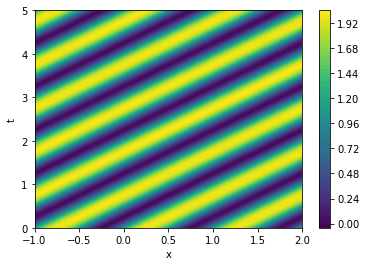

In [63]:
Nd = 400
x = np.linspace(-1, 2, 400)                                  
t = np.linspace(0, 5.0, 400)                                        
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(cuda)
u = to_numpy(model(x_test))
#res = to_numpy(model.res_pde(x_test))
#d   = to_numpy(model.lambda_pde(x_test))
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
#loss = model.loss_pde(x_test)                                 

import matplotlib.pyplot as plt
plt.figure()
plt.figure()
ax = plt.gca()
cset = ax.contourf(x_grid[:,:],t_grid[:,:],ue,60)
#plt.plot(x[:],u_pred[:,0])

plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(cset, ax=ax)
plt.savefig('CombinationWave.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


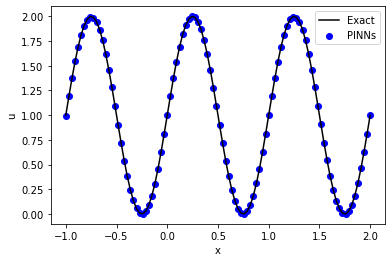

0.1824915825572573

In [64]:
Nd = 400
x = np.linspace(-1.0, 2.0, 100)                                  
t = np.linspace(5, 5, 1)                         
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_e =  x_test - 5
x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(cuda)
u = to_numpy(model(x_test))
#res = to_numpy(model.res_pde(x_test))
#d   = to_numpy(model.lambda_pde(x_test))
u_e = IC_Sin_Case1(x_e) 
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x[:],u_e[:],color='black' ,label='Exact')
plt.scatter(x[:],u[:,0],label='PINNs',color='blue')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
#plt.plot(x[:],Exact_u[:,200])
plt.savefig('CombinationWaveLine.eps', format='eps')
plt.show()

l2_relative_error(u[:,0],u_e)
#np.max(u[:,0]-u_e)

In [55]:

np.max(u[:,0]-u_e)

0.0031184565026672884

In [ ]:

np.max(u[:,0]-u_e)

0.003618223617651406

In [11]:
Nd = 100
x = np.linspace(-0.5, 1.5, 100)                                  
t = np.linspace(0.5, 0.5, 1)                         
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(cuda)
u = to_numpy(model(x_test))
x_e = np.linspace(-0.5, 1.5, Nd)                                  
u_e = np.zeros(Nd)
for i in range(Nd):
    u_e[i] = Combination_wave(x_e[i]-0.5)




In [14]:

l2_relative_error(u[:,0],u_e)

0.008012627163801866